# Wavelet Generative Adversarial Networks
## Initialisation and dataset preparation

First, let us import the required libraries.

In [486]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pywt
from misceallaneous import getWavFileAsNpArray, displaySpectrogram
from IPython.display import Audio
import librosa
import librosa.display
import keras.backend as K

Then, let us include the dataset.

The dataset is made of two files: `clean/p1.wav`and `white/p1.wav` which are converted into arrays of `int32` and then split into segments of `samples_length`.

The goal of the CGAN here is to predict the clean sample, when fed with the white one.

https://medium.com/sicara/keras-generative-adversarial-networks-image-deblurring-45e3ab6977b5

In [583]:
wavelet_family = "db38"

In [584]:
samplerate = 12000
nperseg = 1024

clean = getWavFileAsNpArray("../dataset_2/clean/p1.wav")
white = getWavFileAsNpArray("../dataset_2/white/p1.wav")
clean = np.array(clean, dtype="float32")
white = np.array(white, dtype="float32")

clean_dataset = []
white_dataset = []

samples_length = nperseg*2

for i in range(0, clean.shape[0]-samples_length, samples_length):
    clean_dataset.append(clean[i:i+samples_length])
    white_dataset.append(white[i:i+samples_length])
clean_dataset = np.array(clean_dataset)
white_dataset = np.array(white_dataset)


ex = clean_dataset[0]
ca, cd = pywt.dwt(ex, wavelet_family, "per")
data_shape = ca.shape

In [585]:
wavelet_clean_dataset = []
wavelet_white_dataset = []

for sample in clean_dataset:
    ca, cd = pywt.dwt(sample, wavelet_family, "per")
    wavelet_clean_dataset.append(np.concatenate((ca, cd)))
for sample in white_dataset:
    ca, cd = pywt.dwt(sample, wavelet_family, "per")
    wavelet_white_dataset.append(np.concatenate((ca, cd)))
    
max_clean = np.max(np.abs(wavelet_clean_dataset))*2
wavelet_clean_dataset = np.array(wavelet_clean_dataset)/(max_clean)

max_white = np.max(np.abs(wavelet_white_dataset))*2
wavelet_white_dataset = np.array(wavelet_white_dataset)/(max_white)

print(np.max(wavelet_white_dataset))
print(wavelet_white_dataset.shape)

0.395263
(5329, 2048)


In [586]:
def display_audio(data, g=None, p=0, i=0):
    audio = hear_audio(data, g, p, i)
    D = librosa.stft(audio)
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    librosa.display.specshow(S_db, x_axis='time', y_axis='mel', sr=samplerate)
    #plt.show()
    plt.savefig(str(p)+".png", format='png')
    
def get_ca_cd(data, g=None):
    if g == None:
        ca = data[:data_shape[0]]*max_clean
        cd = data[data_shape[0]:]*max_clean
    else:
        cacd = g.predict(np.reshape(data, (-1, data_shape[0]*2)))[0]
        ca = cacd[:data_shape[0]]*max_clean
        cd = cacd[data_shape[0]:]*max_clean
    return ca, cd

def get_audio(cacd):
    return pywt.idwt(cacd[0], cacd[1], wavelet_family, "per")

def hear_audio(data, g=None, p=0, i=0):
    ca, cd = get_ca_cd(data[i], g=g)
    audio = get_audio((ca, cd))
    return audio

def get_distance_audio(white, clean, g, i):
    return np.sum((get_audio(get_ca_cd(white[i], g)) - get_audio(get_ca_cd(clean[i])))**2)

def get_average_distance_audio(white, clean, g, n):
    res = 0
    for i in range(n):
        res += get_distance_audio(white, clean, g, i)
    return res/(n*100000000)

def get_distance_wavelets(white, clean, g, i):
    d = np.reshape(white[i], (-1, data_shape[0]*2))
    data = (g.predict(d))[0]
    return np.sum((data-clean[i])**2)

def get_average_distance_wavelets(white, clean, g, n):
    res = 0
    for i in range(n):
        res += get_distance_audio(white, clean, g, i)
    return res/n

# Compute standart deviation as well !!!! 

# GAN Model
The main idea of a GAN model is to create two networks who play an adversarial game:
- A Generator, whose goal is to produce the most realistic samples possible to fool the Discriminator
- A Discriminator, whose goal is to correctly guess if its input is a real sample from the clean dataset or an output created by the Generator

In [587]:
def wasserstein_loss(y_true, y_pred):
    return K.mean(K.square(y_true-y_pred))

def get_dense_layer_tanh(size, x):
    return tf.keras.layers.Dense(size, activation="tanh")(x)#, kernel_constraint=tf.keras.constraints.MinMaxNorm(min_value=-0.1, max_value=2/size, rate=1.0, axis=0), bias_constraint=tf.keras.constraints.MinMaxNorm(min_value=-2/size, max_value=2/size, rate=1.0, axis=0),)(x)

def discriminator(sizes, lr=0.0001):
    inputs = tf.keras.Input(shape=(sizes[1]))
    x = tf.keras.layers.Dropout(0.3)(inputs)
    x1 = get_dense_layer_tanh(1024, x)
    x2 = get_dense_layer_tanh(512, x1)
    x3 = get_dense_layer_tanh(64, x2)
    outputs =  tf.keras.layers.Dense(1, activation="sigmoid")(x3)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="discriminator")
    model.summary()
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss=wasserstein_loss, metrics=['accuracy'])
    return model

## Generator
The generator itself is a Convolutionnal Autoencoder.

Its input size and output size are both the size of the stft array.

In [618]:
def perceptual_loss(y_true, y_pred):
     return K.mean(K.square(y_true - y_pred))
                   
def generator(sizes, lr=0.0001):
    inputs = tf.keras.Input(shape=(sizes[1]))
    y = tf.keras.layers.Dropout(0.4)(inputs)
    x = tf.keras.layers.Dropout(0.4)(inputs)
    x1 = tf.keras.layers.Dense(512, activation="tanh")(x)
    x2 = tf.keras.layers.Dense(128, activation="tanh")(x1)
    x3 = tf.keras.layers.Dense(512, activation="tanh")(x2)
    outputs = tf.keras.layers.Dense(sizes[1], activation="tanh")(x3)
    #outputs = tf.keras.layers.Add()([y, x4])
    #outputs = tf.keras.layers.Dense(sizes[1], activation="tanh")(x1)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="autoencoder")
    model.summary()
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss=perceptual_loss, metrics=['accuracy'])
    return model

## Building the GAN

In [619]:
def get_generator_outputs(white, train_size, g, clean):
    steps = train_size//20
    rng = np.random.default_rng()
    g_outputs = []
    batch = rng.choice(white, train_size)
    for i in range(train_size):
        if i%steps == 0:
            print("=", end='')
        t = np.reshape(white[i, :], (-1, white.shape[1]))
        m = g.predict(t)
        g_outputs.append(m)
    print()
    g_outputs = np.reshape(np.array(g_outputs), (train_size,  white.shape[1]))
    input_data = np.concatenate((g_outputs, clean[:train_size,]))
    output_data = np.concatenate((np.zeros((train_size,)), np.ones((train_size,))))
    return input_data, output_data

In [620]:
class GAN:
    def __init__(self, size, g, d, lr=0.0001):
        self.g = g
        self.d = d
        self.d.trainable = False
        self.size = size
        self.lr = lr
        self.build()
        
    def build(self):
        self.z = self.g.inputs
        self.image = self.g(self.z)
        self.valid = self.d(self.image)
        self.combined_network = tf.keras.Model(inputs=self.z, outputs=[self.image, self.valid])
        self.compile()
        
    def compile(self):
        self.combined_network.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.lr), loss=[perceptual_loss, wasserstein_loss], loss_weights=[1, 1], metrics=['accuracy'])

In [621]:
def train_d_on_batch(d, i, o, validation_split=0, batch_size=16, epochs=1, shuffle=True, verbose=True):
    history = d.fit(i, o, batch_size=batch_size, validation_split=validation_split, epochs=epochs, shuffle=shuffle, verbose=verbose)
    val = 'accuracy'
    return history.history[val][-1]

def train_g_on_batch(d, i, o, validation_split=0, batch_size=16, epochs=1, shuffle=True, verbose=True):
    history = d.fit(i, o, batch_size=batch_size, validation_split=validation_split, epochs=epochs, shuffle=shuffle, verbose=verbose)
    val = 'discriminator_accuracy'
    return history.history[val][-1]

In [622]:
g = generator(wavelet_white_dataset.shape)
d = discriminator(wavelet_white_dataset.shape)
gan = GAN(wavelet_white_dataset.shape, g, d)

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_162 (InputLayer)       [(None, 2048)]            0         
_________________________________________________________________
dropout_221 (Dropout)        (None, 2048)              0         
_________________________________________________________________
dense_534 (Dense)            (None, 512)               1049088   
_________________________________________________________________
dense_535 (Dense)            (None, 128)               65664     
_________________________________________________________________
dense_536 (Dense)            (None, 512)               66048     
_________________________________________________________________
dense_537 (Dense)            (None, 2048)              1050624   
Total params: 2,231,424
Trainable params: 2,231,424
Non-trainable params: 0
_____________________________________________

### Training the GAN

In [623]:
discriminator_train_size = 1000#wavelet_white_dataset.shape[0]
generator_train_size = wavelet_white_dataset.shape[0]

In [624]:
p = 1
q = 1
e = 0

In [625]:
disc_acc = []
gen_loss = [0]
gan_acc = []
g_accuracy = 0

Step 0
Training the discriminator
125/125 [==============================] - 2s 14ms/step - loss: 0.1701 - accuracy: 0.7830
Training the generator
334/334 [==============================] - 10s 25ms/step - loss: 0.0867 - autoencoder_loss: 0.0044 - discriminator_loss: 0.0824 - autoencoder_accuracy: 3.6844e-04 - discriminator_accuracy: 0.8696
Audio MSE: 863.9614405632
334/334 [==============================] - 9s 25ms/step - loss: 0.0050 - autoencoder_loss: 0.0044 - discriminator_loss: 6.2995e-04 - autoencoder_accuracy: 7.5061e-04 - discriminator_accuracy: 0.9996
Audio MSE: 826.9368527872
334/334 [==============================] - 7s 21ms/step - loss: 0.0043 - autoencoder_loss: 0.0042 - discriminator_loss: 1.0926e-04 - autoencoder_accuracy: 3.7530e-04 - discriminator_accuracy: 1.0000
Audio MSE: 786.7419556864
Step 1
Training the discriminator
125/125 [==============================] - 2s 16ms/step - loss: 0.0033 - accuracy: 1.0000
Training the generator
334/334 [=========================

334/334 [==============================] - 5s 16ms/step - loss: 0.0275 - autoencoder_loss: 0.0050 - discriminator_loss: 0.0225 - autoencoder_accuracy: 3.7530e-04 - discriminator_accuracy: 0.9976
Audio MSE: 948.587706368
334/334 [==============================] - 7s 21ms/step - loss: 0.0259 - autoencoder_loss: 0.0044 - discriminator_loss: 0.0215 - autoencoder_accuracy: 1.8765e-04 - discriminator_accuracy: 0.9991
Audio MSE: 798.3972886528
334/334 [==============================] - 8s 23ms/step - loss: 0.0249 - autoencoder_loss: 0.0039 - discriminator_loss: 0.0210 - autoencoder_accuracy: 1.8765e-04 - discriminator_accuracy: 0.9996
Audio MSE: 741.2277504
334/334 [==============================] - 6s 18ms/step - loss: 0.0245 - autoencoder_loss: 0.0038 - discriminator_loss: 0.0207 - autoencoder_accuracy: 0.0000e+00 - discriminator_accuracy: 1.0000
Audio MSE: 678.3348849664
Step 8
Training the discriminator
125/125 [==============================] - 1s 11ms/step - loss: 0.0021 - accuracy: 1.0

334/334 [==============================] - 5s 16ms/step - loss: 0.0818 - autoencoder_loss: 0.0077 - discriminator_loss: 0.0741 - autoencoder_accuracy: 0.0019 - discriminator_accuracy: 0.9041
Audio MSE: 1186.8789215232
334/334 [==============================] - 5s 15ms/step - loss: 0.0061 - autoencoder_loss: 0.0051 - discriminator_loss: 0.0010 - autoencoder_accuracy: 0.0015 - discriminator_accuracy: 0.9998
Audio MSE: 812.8717901824
334/334 [==============================] - 5s 16ms/step - loss: 0.0047 - autoencoder_loss: 0.0038 - discriminator_loss: 8.5890e-04 - autoencoder_accuracy: 0.0026 - discriminator_accuracy: 1.0000
Audio MSE: 650.0271574016
Step 15
Training the discriminator
125/125 [==============================] - 1s 8ms/step - loss: 0.0015 - accuracy: 1.0000
Training the generator
334/334 [==============================] - 5s 16ms/step - loss: 0.0896 - autoencoder_loss: 0.0146 - discriminator_loss: 0.0750 - autoencoder_accuracy: 9.3826e-04 - discriminator_accuracy: 0.9067
Au

334/334 [==============================] - 5s 16ms/step - loss: 0.0119 - autoencoder_loss: 0.0053 - discriminator_loss: 0.0065 - autoencoder_accuracy: 0.0030 - discriminator_accuracy: 0.9996
Audio MSE: 1021.4444814336
334/334 [==============================] - 5s 16ms/step - loss: 0.0133 - autoencoder_loss: 0.0063 - discriminator_loss: 0.0071 - autoencoder_accuracy: 0.0030 - discriminator_accuracy: 0.9992
Audio MSE: 1363.2607551488
Step 19
Training the discriminator
125/125 [==============================] - 1s 9ms/step - loss: 0.0226 - accuracy: 1.0000
Training the generator
334/334 [==============================] - 6s 17ms/step - loss: 0.4533 - autoencoder_loss: 0.0076 - discriminator_loss: 0.4458 - autoencoder_accuracy: 3.7530e-04 - discriminator_accuracy: 0.3883
Audio MSE: 1391.9725756416
334/334 [==============================] - 6s 18ms/step - loss: 0.0672 - autoencoder_loss: 0.0047 - discriminator_loss: 0.0625 - autoencoder_accuracy: 0.0019 - discriminator_accuracy: 0.9996
Audi

334/334 [==============================] - 5s 15ms/step - loss: 0.7789 - autoencoder_loss: 0.0013 - discriminator_loss: 0.7776 - autoencoder_accuracy: 0.0285 - discriminator_accuracy: 0.0000e+00
Audio MSE: 238.994847744
334/334 [==============================] - 5s 16ms/step - loss: 0.7789 - autoencoder_loss: 0.0013 - discriminator_loss: 0.7776 - autoencoder_accuracy: 0.0291 - discriminator_accuracy: 0.0000e+00
Audio MSE: 230.6280489984
334/334 [==============================] - 5s 16ms/step - loss: 0.7789 - autoencoder_loss: 0.0012 - discriminator_loss: 0.7776 - autoencoder_accuracy: 0.0304 - discriminator_accuracy: 0.0000e+00
Audio MSE: 228.4139390976
334/334 [==============================] - 5s 16ms/step - loss: 0.7788 - autoencoder_loss: 0.0012 - discriminator_loss: 0.7776 - autoencoder_accuracy: 0.0379 - discriminator_accuracy: 0.0000e+00
Audio MSE: 224.4809145344
Step 23
Training the discriminator
125/125 [==============================] - 1s 8ms/step - loss: 0.0061 - accuracy: 

334/334 [==============================] - 7s 20ms/step - loss: 0.8082 - autoencoder_loss: 0.0021 - discriminator_loss: 0.8060 - autoencoder_accuracy: 0.0353 - discriminator_accuracy: 1.8765e-04
Audio MSE: 1012.2249216
334/334 [==============================] - 6s 19ms/step - loss: 0.5109 - autoencoder_loss: 0.0439 - discriminator_loss: 0.4669 - autoencoder_accuracy: 0.0034 - discriminator_accuracy: 0.0182
Audio MSE: 7551.699337216
334/334 [==============================] - 8s 24ms/step - loss: 0.0276 - autoencoder_loss: 0.0131 - discriminator_loss: 0.0145 - autoencoder_accuracy: 0.0084 - discriminator_accuracy: 0.9775
Audio MSE: 1160.8366579712
334/334 [==============================] - 5s 16ms/step - loss: 0.0040 - autoencoder_loss: 0.0037 - discriminator_loss: 3.1309e-04 - autoencoder_accuracy: 0.0199 - discriminator_accuracy: 0.9998
Audio MSE: 511.1063015424
334/334 [==============================] - 6s 19ms/step - loss: 0.0032 - autoencoder_loss: 0.0022 - discriminator_loss: 0.001

334/334 [==============================] - 6s 17ms/step - loss: 0.0035 - autoencoder_loss: 0.0021 - discriminator_loss: 0.0014 - autoencoder_accuracy: 0.0184 - discriminator_accuracy: 0.9998
Audio MSE: 383.227969024
334/334 [==============================] - 5s 16ms/step - loss: 0.0030 - autoencoder_loss: 0.0018 - discriminator_loss: 0.0012 - autoencoder_accuracy: 0.0188 - discriminator_accuracy: 1.0000
Audio MSE: 335.9721778688
Step 32
Training the discriminator
125/125 [==============================] - 1s 9ms/step - loss: 0.0012 - accuracy: 1.0000
Training the generator
334/334 [==============================] - 5s 15ms/step - loss: 0.0628 - autoencoder_loss: 0.0046 - discriminator_loss: 0.0582 - autoencoder_accuracy: 0.0060 - discriminator_accuracy: 0.9328
Audio MSE: 825.0151604224
334/334 [==============================] - 7s 22ms/step - loss: 0.0043 - autoencoder_loss: 0.0032 - discriminator_loss: 0.0011 - autoencoder_accuracy: 0.0075 - discriminator_accuracy: 1.0000
Audio MSE: 5

334/334 [==============================] - 6s 17ms/step - loss: 0.0104 - autoencoder_loss: 0.0023 - discriminator_loss: 0.0080 - autoencoder_accuracy: 0.0088 - discriminator_accuracy: 0.9955
Audio MSE: 476.46112512
334/334 [==============================] - 5s 16ms/step - loss: 0.0107 - autoencoder_loss: 0.0023 - discriminator_loss: 0.0083 - autoencoder_accuracy: 0.0116 - discriminator_accuracy: 0.9951
Audio MSE: 469.7729154048
334/334 [==============================] - 6s 17ms/step - loss: 0.0090 - autoencoder_loss: 0.0024 - discriminator_loss: 0.0066 - autoencoder_accuracy: 0.0109 - discriminator_accuracy: 0.9979
Audio MSE: 470.9553201152
334/334 [==============================] - 6s 18ms/step - loss: 0.0070 - autoencoder_loss: 0.0023 - discriminator_loss: 0.0047 - autoencoder_accuracy: 0.0107 - discriminator_accuracy: 1.0000
Audio MSE: 433.8746729472
Step 39
Training the discriminator
125/125 [==============================] - 1s 10ms/step - loss: 0.0037 - accuracy: 1.0000
Training 

125/125 [==============================] - 1s 9ms/step - loss: 0.0013 - accuracy: 1.0000
Training the generator
334/334 [==============================] - 5s 16ms/step - loss: 0.1000 - autoencoder_loss: 0.0027 - discriminator_loss: 0.0973 - autoencoder_accuracy: 0.0094 - discriminator_accuracy: 0.8921
Audio MSE: 546.0740760576
334/334 [==============================] - 6s 19ms/step - loss: 0.0044 - autoencoder_loss: 0.0026 - discriminator_loss: 0.0018 - autoencoder_accuracy: 0.0120 - discriminator_accuracy: 1.0000
Audio MSE: 521.0757085184
Step 45
Training the discriminator
125/125 [==============================] - 1s 10ms/step - loss: 9.1239e-04 - accuracy: 1.0000
Training the generator
334/334 [==============================] - 6s 17ms/step - loss: 0.0676 - autoencoder_loss: 0.0028 - discriminator_loss: 0.0648 - autoencoder_accuracy: 0.0075 - discriminator_accuracy: 0.9293
Audio MSE: 593.3606639616
334/334 [==============================] - 7s 20ms/step - loss: 0.0044 - autoencoder_

334/334 [==============================] - 6s 18ms/step - loss: 0.0048 - autoencoder_loss: 0.0030 - discriminator_loss: 0.0018 - autoencoder_accuracy: 0.0062 - discriminator_accuracy: 0.9992
Audio MSE: 598.9568443392
334/334 [==============================] - 6s 19ms/step - loss: 0.0038 - autoencoder_loss: 0.0028 - discriminator_loss: 9.5647e-04 - autoencoder_accuracy: 0.0062 - discriminator_accuracy: 0.9998
Audio MSE: 566.576975872
334/334 [==============================] - 7s 19ms/step - loss: 0.0036 - autoencoder_loss: 0.0027 - discriminator_loss: 8.5888e-04 - autoencoder_accuracy: 0.0084 - discriminator_accuracy: 1.0000
Audio MSE: 539.0669063168
Step 50
Training the discriminator
125/125 [==============================] - 1s 9ms/step - loss: 0.0011 - accuracy: 1.0000
Training the generator
334/334 [==============================] - 5s 16ms/step - loss: 0.1009 - autoencoder_loss: 0.0033 - discriminator_loss: 0.0976 - autoencoder_accuracy: 0.0066 - discriminator_accuracy: 0.8861
Audi

125/125 [==============================] - 1s 9ms/step - loss: 0.0013 - accuracy: 1.0000
Training the generator
334/334 [==============================] - 5s 16ms/step - loss: 0.0848 - autoencoder_loss: 0.0029 - discriminator_loss: 0.0819 - autoencoder_accuracy: 0.0045 - discriminator_accuracy: 0.9049
Audio MSE: 662.1133083648
334/334 [==============================] - 6s 18ms/step - loss: 0.0188 - autoencoder_loss: 0.0037 - discriminator_loss: 0.0152 - autoencoder_accuracy: 0.0017 - discriminator_accuracy: 0.9837
Audio MSE: 763.7260029952
334/334 [==============================] - 7s 20ms/step - loss: 0.0072 - autoencoder_loss: 0.0035 - discriminator_loss: 0.0037 - autoencoder_accuracy: 0.0023 - discriminator_accuracy: 0.9976
Audio MSE: 730.8523718656
334/334 [==============================] - 6s 18ms/step - loss: 0.0055 - autoencoder_loss: 0.0034 - discriminator_loss: 0.0021 - autoencoder_accuracy: 0.0013 - discriminator_accuracy: 0.9994
Audio MSE: 670.5474199552
334/334 [===========

334/334 [==============================] - 6s 17ms/step - loss: 0.0083 - autoencoder_loss: 0.0029 - discriminator_loss: 0.0054 - autoencoder_accuracy: 0.0032 - discriminator_accuracy: 0.9994
Audio MSE: 588.3490708992
334/334 [==============================] - 6s 18ms/step - loss: 0.0077 - autoencoder_loss: 0.0028 - discriminator_loss: 0.0049 - autoencoder_accuracy: 0.0054 - discriminator_accuracy: 1.0000
Audio MSE: 555.3514617344
Step 59
Training the discriminator
125/125 [==============================] - 1s 9ms/step - loss: 0.0028 - accuracy: 1.0000
Training the generator
334/334 [==============================] - 5s 16ms/step - loss: 0.0594 - autoencoder_loss: 0.0032 - discriminator_loss: 0.0562 - autoencoder_accuracy: 0.0026 - discriminator_accuracy: 0.9381
Audio MSE: 710.6819941376
334/334 [==============================] - 6s 18ms/step - loss: 0.0092 - autoencoder_loss: 0.0032 - discriminator_loss: 0.0060 - autoencoder_accuracy: 0.0039 - discriminator_accuracy: 0.9977
Audio MSE: 

334/334 [==============================] - 8s 25ms/step - loss: 0.0087 - autoencoder_loss: 0.0029 - discriminator_loss: 0.0057 - autoencoder_accuracy: 0.0034 - discriminator_accuracy: 0.9979
Audio MSE: 623.9680413696
334/334 [==============================] - 6s 18ms/step - loss: 0.0079 - autoencoder_loss: 0.0031 - discriminator_loss: 0.0048 - autoencoder_accuracy: 0.0024 - discriminator_accuracy: 0.9987
Audio MSE: 635.84524544
334/334 [==============================] - 6s 17ms/step - loss: 0.0067 - autoencoder_loss: 0.0029 - discriminator_loss: 0.0038 - autoencoder_accuracy: 0.0026 - discriminator_accuracy: 1.0000
Audio MSE: 587.9544313344
Step 64
Training the discriminator
125/125 [==============================] - 2s 16ms/step - loss: 0.0013 - accuracy: 1.0000
Training the generator
334/334 [==============================] - 6s 19ms/step - loss: 0.0721 - autoencoder_loss: 0.0029 - discriminator_loss: 0.0692 - autoencoder_accuracy: 0.0034 - discriminator_accuracy: 0.9246
Audio MSE: 6

KeyboardInterrupt: 

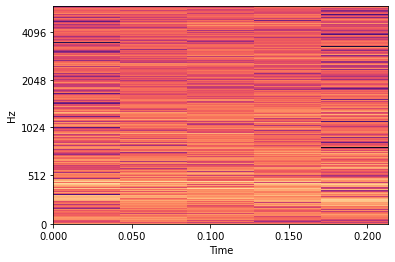

In [626]:
while e < 120:
    d_accuracy = 0
    print("Step", e)
    e+=1
    print("Training the discriminator")
    i, o = get_generator_outputs(wavelet_white_dataset, discriminator_train_size, gan.g, wavelet_clean_dataset)
    it = 0
    while (it < 10 or d_accuracy < g_accuracy) and d_accuracy < 1:
        it += 1
        d_accuracy = train_d_on_batch(gan.d, i, o, verbose=True)
        disc_acc.append(d_accuracy)
        gan_acc.append(0)
    print("Training the generator")
    g_accuracy = 0
    it = 0
    while it < 10 and g_accuracy < 1:
        it += 1
        g_accuracy = train_g_on_batch(gan.combined_network, wavelet_white_dataset[:generator_train_size], [wavelet_clean_dataset[:generator_train_size], np.ones(generator_train_size)], verbose=True)
        gan_acc.append(g_accuracy)
        disc_acc.append(0)
        err = get_average_distance_audio(wavelet_white_dataset, wavelet_clean_dataset, gan.g, 100)
        print("Audio MSE:", err)
        gen_loss.append(err)
        display_audio(wavelet_white_dataset, gan.g, p)
        p+=1
plt.plot(disc_acc)
plt.plot(gan_acc)
plt.show()
plt.plot(gen_loss[1:])
plt.show()

In [ ]:
## gan.combined_network.save('save4/gan_with_add')

In [581]:
res = []
for i in range(10):
    res.append(hear_audio(wavelet_white_dataset, i=i))
audio = np.concatenate(res)
Audio(audio, rate=samplerate)

In [627]:
res = []
for i in range(10):
    res.append(hear_audio(wavelet_white_dataset, g=gan.g, i=i))
audio = np.concatenate(res)
Audio(audio, rate=samplerate)

In [ ]:
res = []
for i in range(10):
    res.append(hear_audio(wavelet_clean_dataset, i=i))
audio = np.concatenate(res)
Audio(audio, rate=samplerate)